# 06 - Tree Visualization System

This notebook demonstrates the **L-system tree generation and stained-glass rendering** system.

**Key features:**
- Recursive L-system branching with configurable depth and angles
- Parametric leaf geometry with equal-area vein panels
- Quadratic Bézier curved veins for natural appearance
- Multiple blossom/fruit types (cherry, apple, wildflowers)
- Stress-responsive visualization integration

**This enables:**
- **Procedural tree generation**: Deterministic trees from seed values
- **Parameter-driven morphology**: Depth, angles, and sparseness control form
- **Visual stress indicators**: Leaf colors and structure reflect environmental conditions
- **Publication-quality output**: Stained-glass aesthetic for presentations

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sim.stained_glass import (
    TreeParams,
    TreeStyle,
    TreeSkeleton,
    generate_tree_skeleton,
    render_tree,
    save_tree,
    make_leaf,
    LeafGeom,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 11

## 1. Tree Complexity: Depth Comparison

The `depth` parameter controls recursive branching complexity:
- Depth 3: Simple structure (few branches)
- Depth 5: Moderate complexity (balanced)
- Depth 7: Dense canopy (publication quality)

In [2]:
# Show default TreeParams
params = TreeParams()
print("Default TreeParams:")
print("-" * 40)
print(f"  depth:          {params.depth} (recursion levels)")
print(f"  angle:          {params.angle}° (branch spread)")
print(f"  scale:          {params.scale} (child/parent ratio)")
print(f"  trunk_length:   {params.trunk_length} (pixels)")
print(f"  thickness:      {params.thickness} (trunk width)")
print(f"  randomness:     {params.randomness} (angle jitter)")
print(f"  early_stop:     {params.early_stop} (pruning probability)")
print(f"  show_leaves:    {params.show_leaves}")
print(f"  show_blossoms:  {params.show_blossoms}")
print(f"  blossom_type:   {params.blossom_type}")

Default TreeParams:
----------------------------------------
  depth:          5 (recursion levels)
  angle:          28.0° (branch spread)
  scale:          0.68 (child/parent ratio)
  trunk_length:   120.0 (pixels)
  thickness:      6.0 (trunk width)
  randomness:     0.1 (angle jitter)
  early_stop:     0.15 (pruning probability)
  show_leaves:    True
  show_blossoms:  False
  blossom_type:   cherry


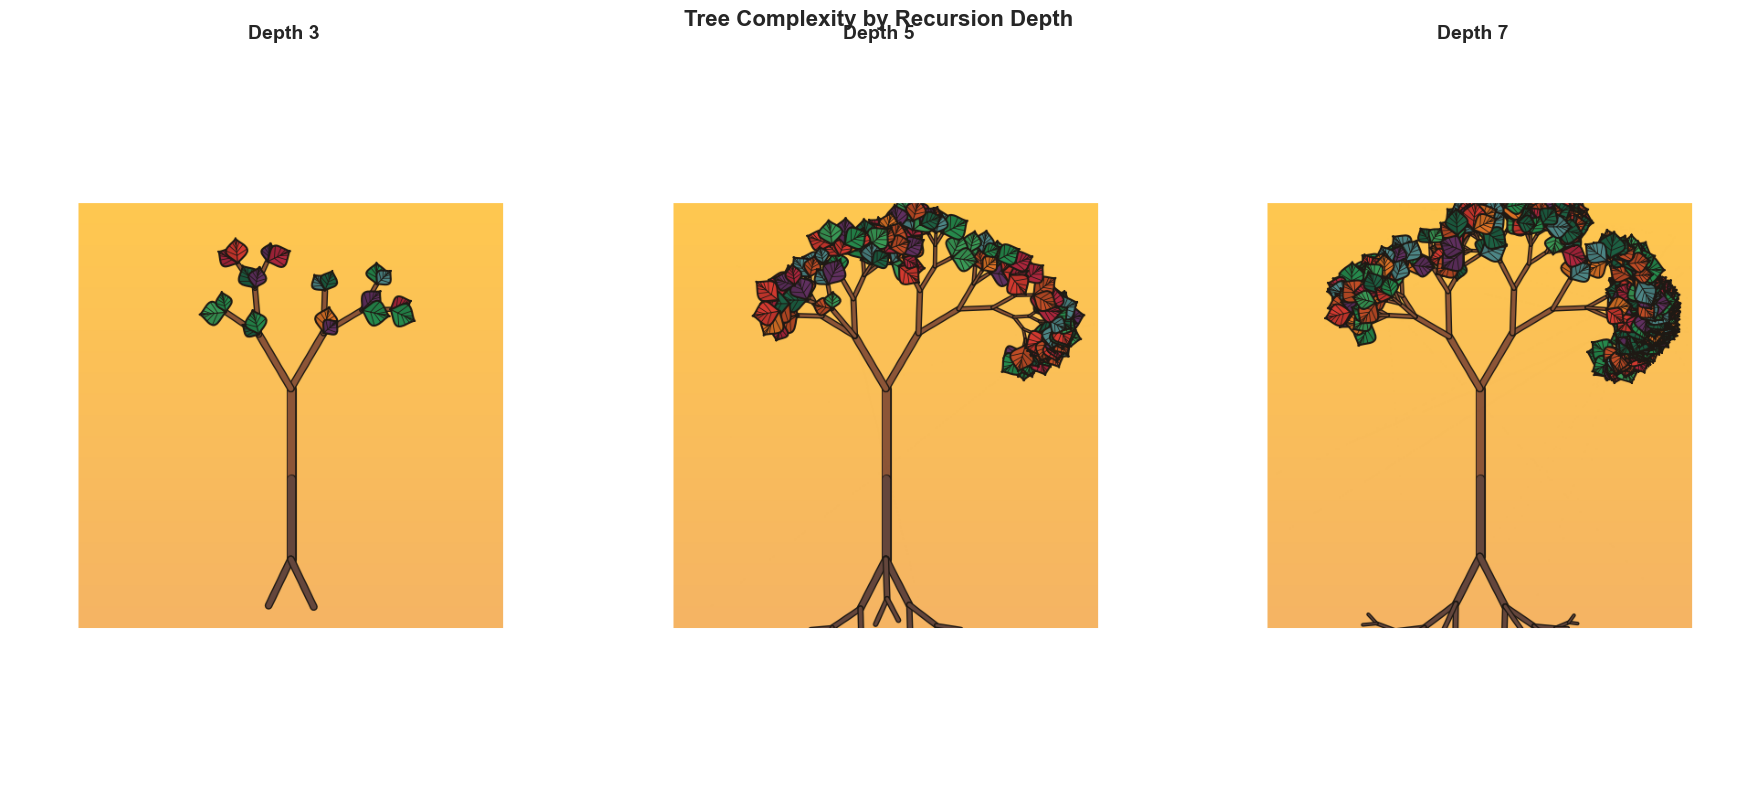

In [3]:
# Compare tree complexity at different depths
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

depths = [3, 5, 7]
for ax, depth in zip(axes, depths):
    params = TreeParams(depth=depth, show_blossoms=False)
    render_tree(params, seed=42, figsize=(6, 8))
    plt.close()  # Close the auto-created figure
    
    # Re-render into our subplot
    fig_temp, ax_temp = render_tree(params, seed=42, figsize=(6, 8))
    
    # Copy content via image
    fig_temp.canvas.draw()
    img = np.frombuffer(fig_temp.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig_temp.canvas.get_width_height()[::-1] + (4,))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Depth {depth}', fontsize=14, fontweight='bold')
    plt.close(fig_temp)

plt.suptitle('Tree Complexity by Recursion Depth', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

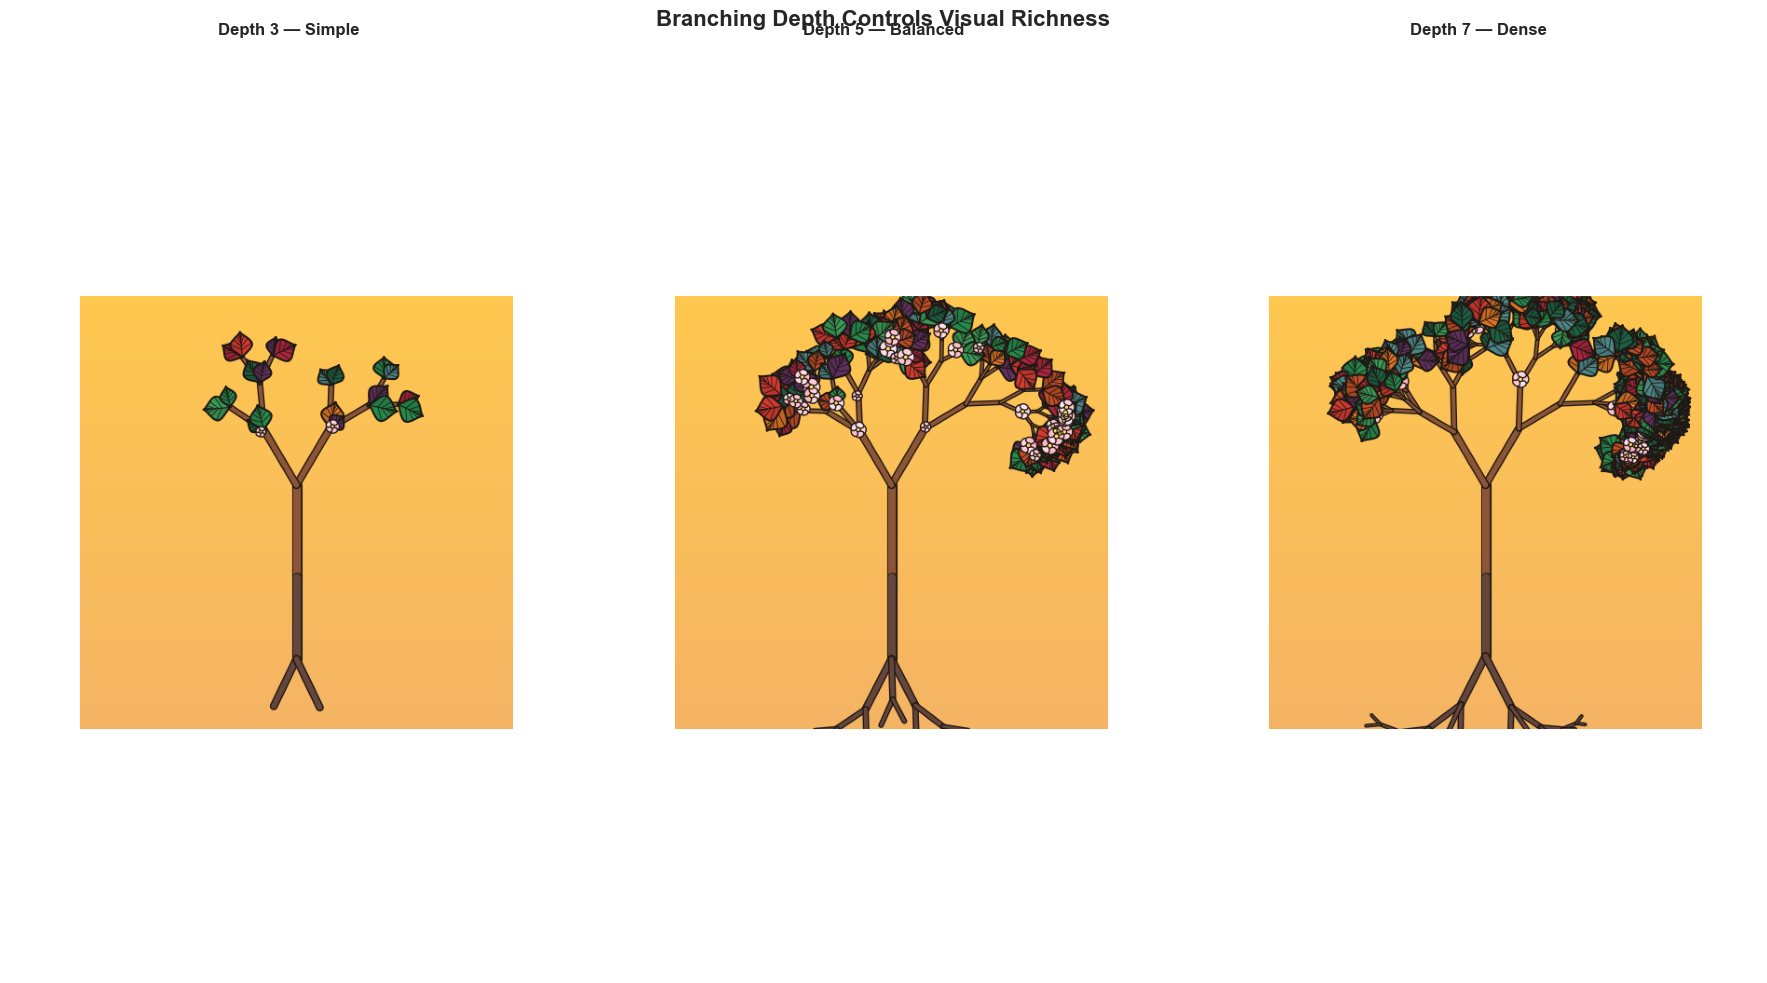

In [4]:
# Side-by-side depth comparison with leaf details
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

configs = [
    (3, 'Depth 3 — Simple'),
    (5, 'Depth 5 — Balanced'),
    (7, 'Depth 7 — Dense'),
]

for ax, (depth, title) in zip(axes, configs):
    params = TreeParams(depth=depth, show_blossoms=True, blossom_density=0.3)
    fig_temp, _ = render_tree(params, seed=42, figsize=(6, 10))
    
    fig_temp.canvas.draw()
    img = np.frombuffer(fig_temp.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig_temp.canvas.get_width_height()[::-1] + (4,))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.close(fig_temp)

plt.suptitle('Branching Depth Controls Visual Richness', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Hero Image

A full-resolution tree with cherry blossoms demonstrating the stained-glass aesthetic.

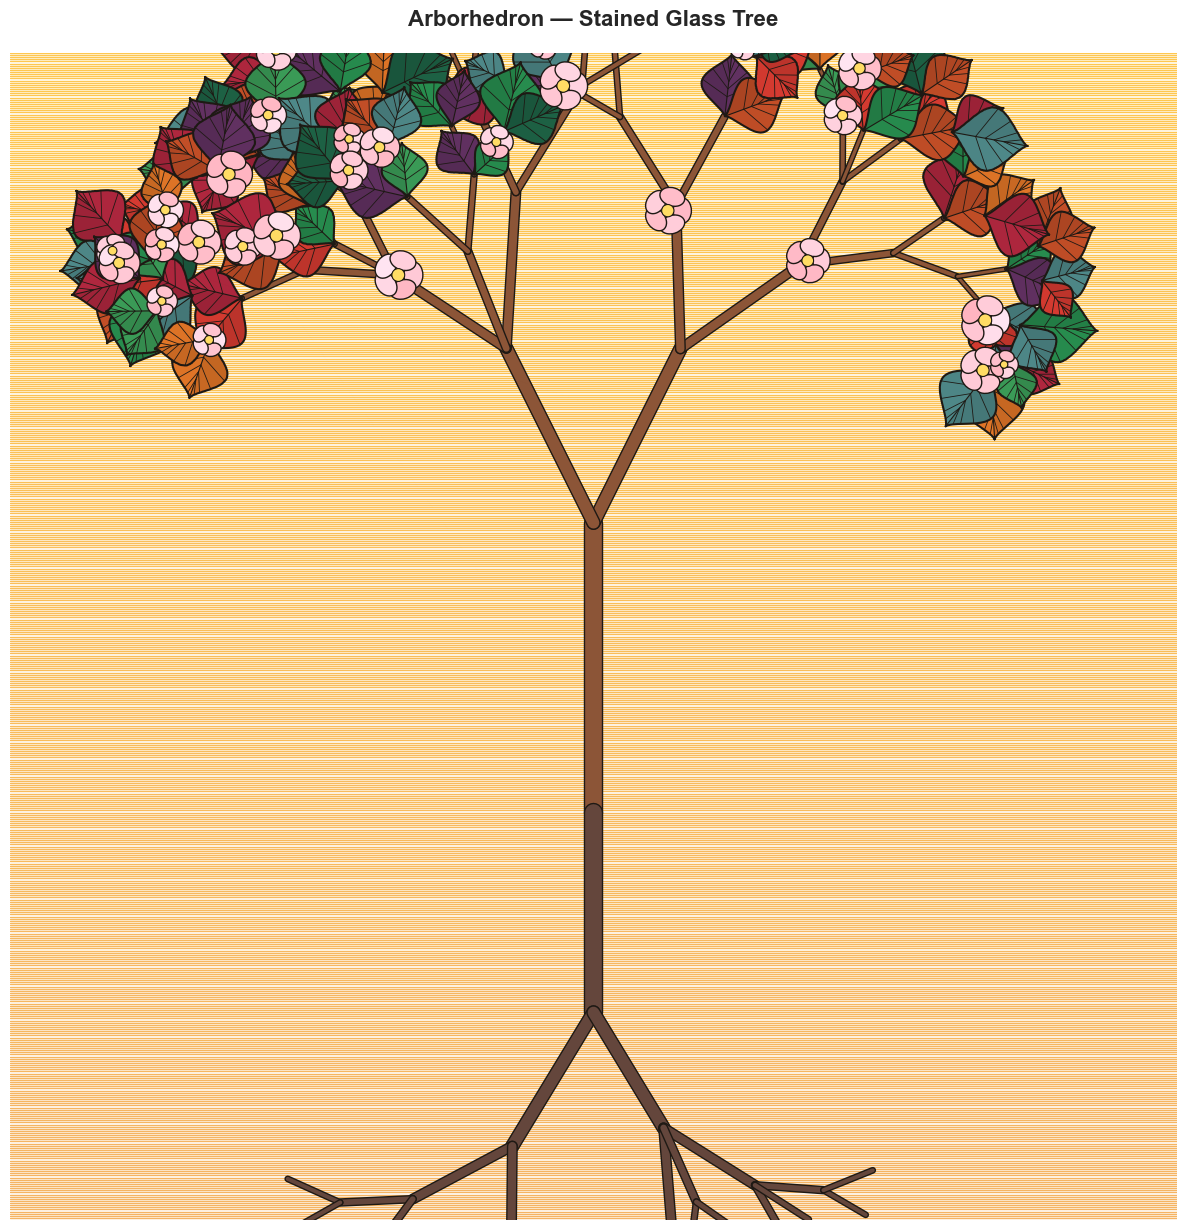

In [5]:
# Create hero image with cherry blossoms
hero_params = TreeParams(
    depth=6,
    angle=28,
    scale=0.72,
    trunk_length=130,
    thickness=12,
    randomness=0.12,
    early_stop=0.12,
    show_leaves=True,
    show_blossoms=True,
    blossom_type='cherry',
    blossom_density=0.45,
)

hero_style = TreeStyle(
    leaf_colors=(
        '#b42840', '#dc3c32', '#c85028',
        '#e67828', '#289050', '#3ca05a',
        '#1e6446', '#643264', '#508c8c'
    ),
)

fig, ax = render_tree(hero_params, hero_style, seed=123, figsize=(12, 14))
ax.set_title('Arborhedron — Stained Glass Tree', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
fig.savefig('stained_glass_hero.png', dpi=150, bbox_inches='tight', facecolor='#f5deb3')
plt.show()

## 3. Parameter-Driven Morphology

Tree parameters control morphological outcomes:
- `early_stop`: Higher values create sparser, more pruned forms
- `angle`: Controls branch spread (tight vs. wide)
- `randomness`: Adds natural variation to branching angles

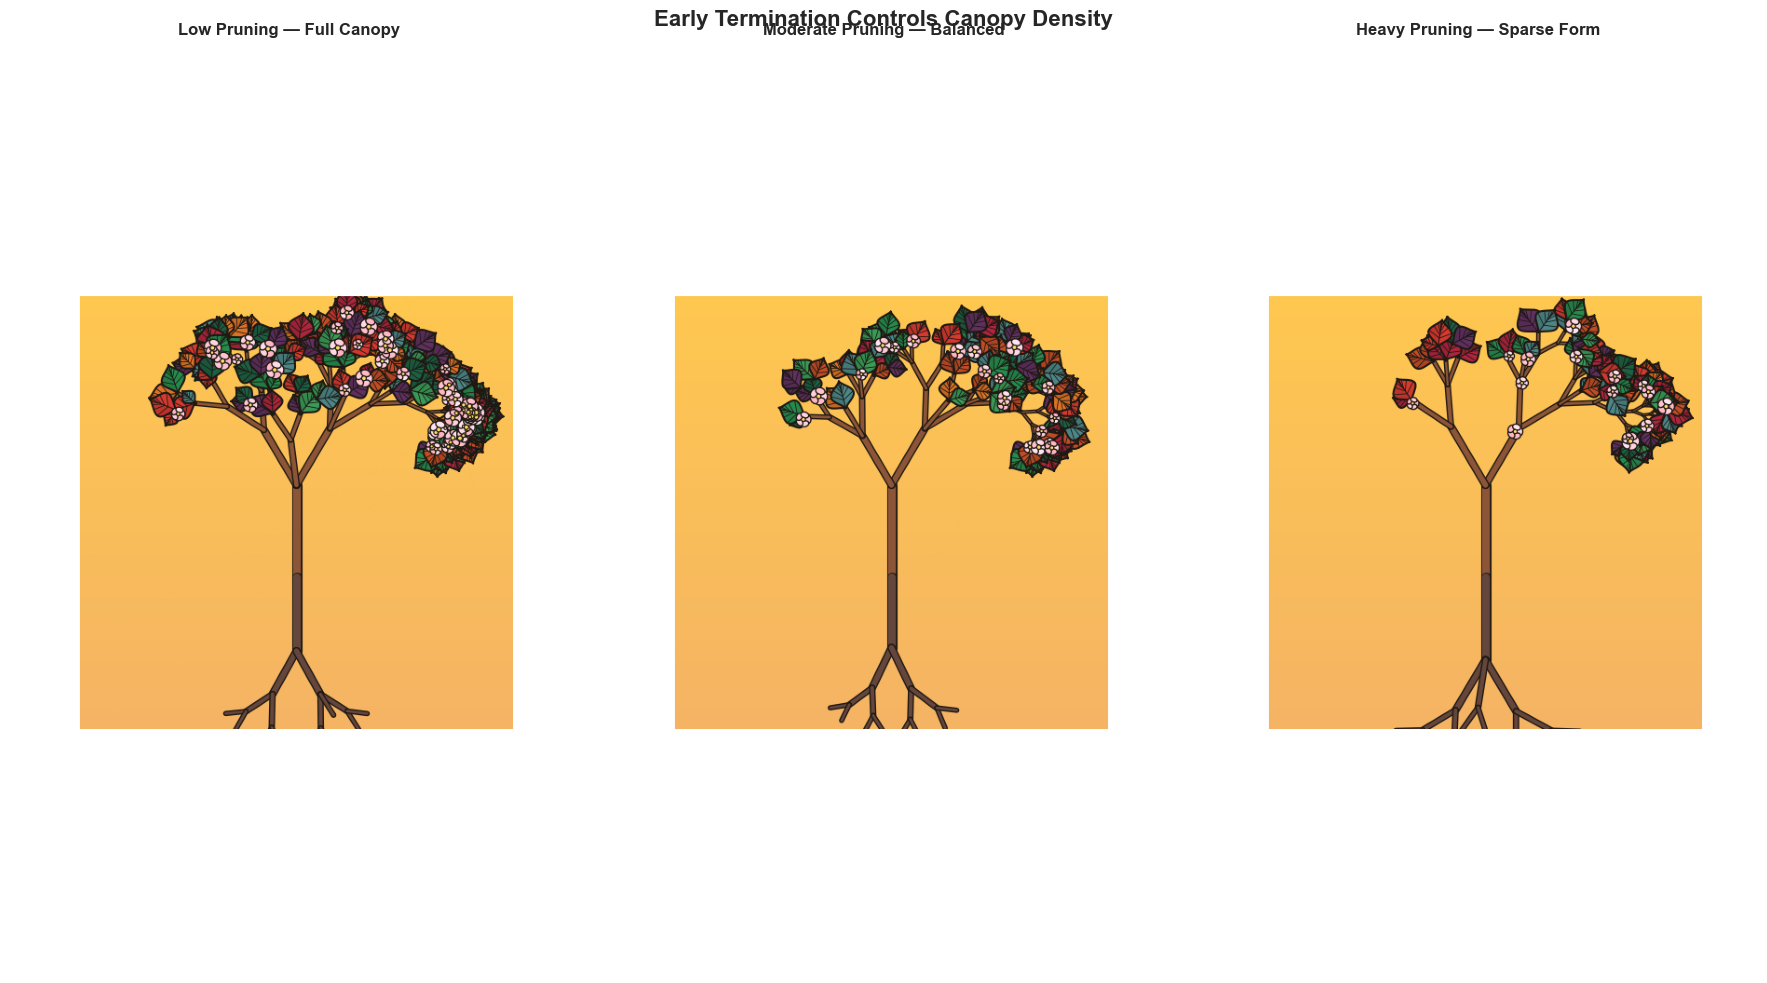

In [6]:
# Morphology comparison via early_stop parameter
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

configs = [
    (0.05, 'Low Pruning — Full Canopy'),
    (0.25, 'Moderate Pruning — Balanced'),
    (0.45, 'Heavy Pruning — Sparse Form'),
]

for ax, (early_stop, title) in zip(axes, configs):
    params = TreeParams(
        depth=5,
        early_stop=early_stop,
        show_blossoms=True,
        blossom_density=0.3 * (1 - early_stop),
    )
    fig_temp, _ = render_tree(params, seed=42, figsize=(6, 10))
    
    fig_temp.canvas.draw()
    img = np.frombuffer(fig_temp.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig_temp.canvas.get_width_height()[::-1] + (4,))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.close(fig_temp)

plt.suptitle('Early Termination Controls Canopy Density', fontsize=16, fontweight='bold')
plt.tight_layout()
fig.savefig('stress_morphology.png', dpi=150, bbox_inches='tight', facecolor='#f5deb3')
plt.show()

## 4. Leaf Geometry System

Each leaf uses a parametric profile with equal-area vein panels:
- Profile: `half_width(t) = sin(πt)^sharpness`
- Veins divide the leaf into panels of equal area
- Quadratic Bézier curves create natural vein curvature

Leaf Geometry Parameters:
----------------------------------------
  length:     1.0
  max_width:  0.4
  sharpness:  1.8 (higher = more pointed)
  rotation:   90°


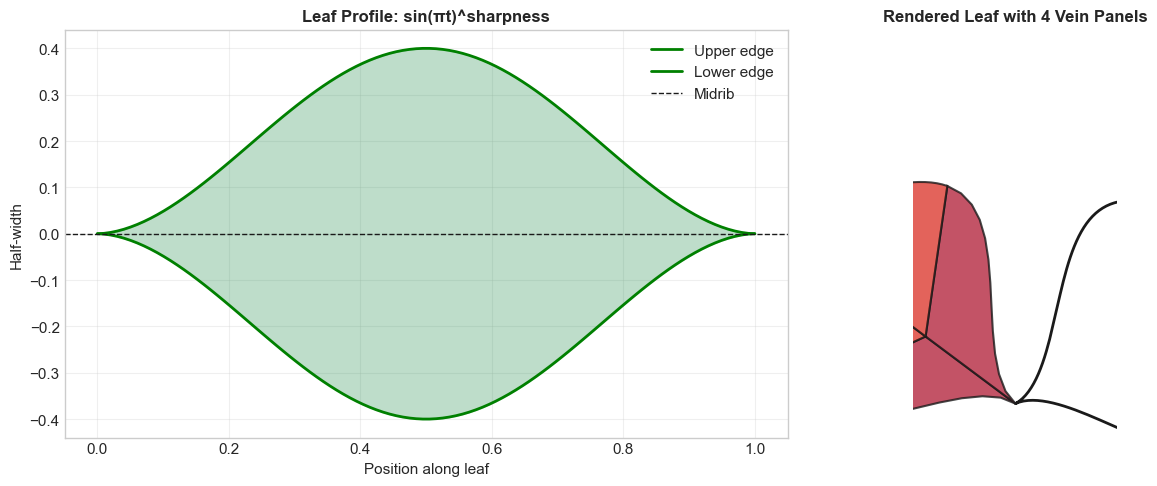

In [7]:
# Demonstrate leaf geometry
import math

# Create a leaf geometry
geom = LeafGeom(x=0, y=0, length=1.0, max_width=0.4, sharpness=1.8, rotation=90)

print("Leaf Geometry Parameters:")
print("-" * 40)
print(f"  length:     {geom.length}")
print(f"  max_width:  {geom.max_width}")
print(f"  sharpness:  {geom.sharpness} (higher = more pointed)")
print(f"  rotation:   {geom.rotation}°")

# Show how the profile works
t_vals = np.linspace(0, 1, 100)
half_widths = np.array([geom.half_width_at(t) for t in t_vals])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: profile curve
ax1.fill_between(t_vals * geom.length, -half_widths, half_widths, alpha=0.3, color='#289050')
ax1.plot(t_vals * geom.length, half_widths, 'g-', linewidth=2, label='Upper edge')
ax1.plot(t_vals * geom.length, -half_widths, 'g-', linewidth=2, label='Lower edge')
ax1.axhline(0, color='#1a1a1a', linewidth=1, linestyle='--', label='Midrib')
ax1.set_xlabel('Position along leaf', fontsize=11)
ax1.set_ylabel('Half-width', fontsize=11)
ax1.set_title('Leaf Profile: sin(πt)^sharpness', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: render using TreeStyle to show vein panels
style = TreeStyle(n_veins=4, vein_angle=55)

# Get vein panels for visualization
n_veins = style.n_veins
panels = geom.get_vein_panels(n_veins, angle_deg=style.vein_angle, curve=style.vein_curve)

# Draw panels
colors = ['#b42840', '#dc3c32', '#289050', '#3ca05a', '#e67828']
for i, (r_panel, l_panel) in enumerate(zip(panels['right'], panels['left'])):
    r_world = [geom.to_world(p) for p in r_panel]
    l_world = [geom.to_world(p) for p in l_panel]
    
    color = colors[i % len(colors)]
    r_xs, r_ys = zip(*r_world)
    l_xs, l_ys = zip(*l_world)
    
    ax2.fill(r_xs, r_ys, color=color, alpha=0.8, edgecolor='#1a1a1a', linewidth=1.5)
    ax2.fill(l_xs, l_ys, color=color, alpha=0.8, edgecolor='#1a1a1a', linewidth=1.5)

# Draw outline
outline = geom.get_outline_polygon()
ox, oy = zip(*outline)
ax2.plot(ox, oy, color='#1a1a1a', linewidth=2)

ax2.set_xlim(-0.3, 0.3)
ax2.set_ylim(-0.1, 1.1)
ax2.set_aspect('equal')
ax2.set_title(f'Rendered Leaf with {n_veins} Vein Panels', fontsize=12, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

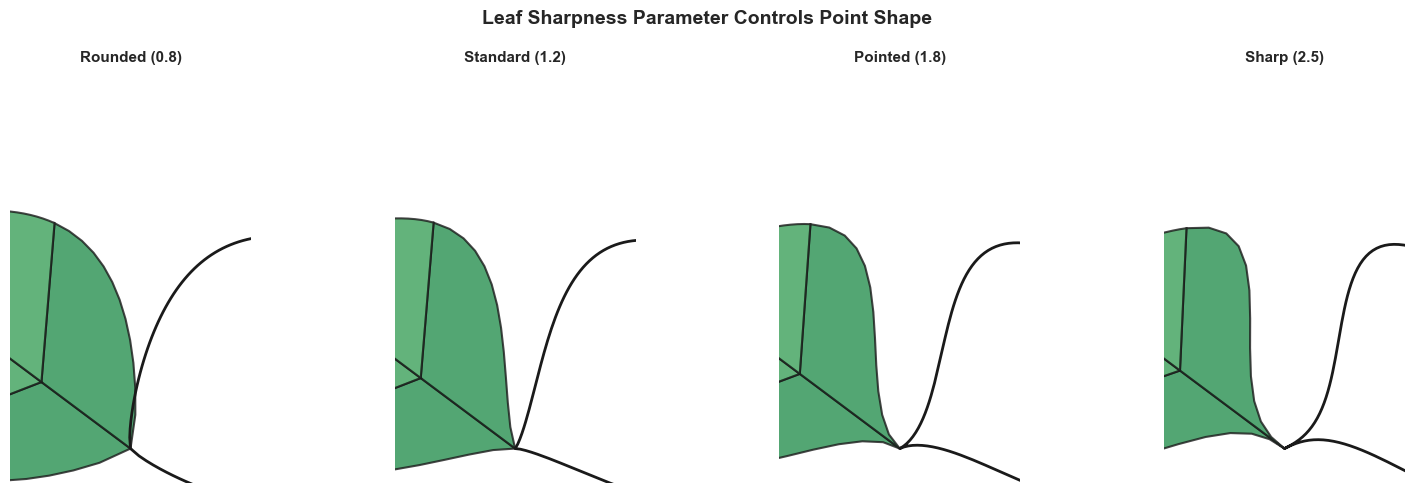

In [8]:
# Show leaf variations with different sharpness values
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

sharpness_vals = [0.8, 1.2, 1.8, 2.5]
titles = ['Rounded (0.8)', 'Standard (1.2)', 'Pointed (1.8)', 'Sharp (2.5)']
colors = ['#289050', '#3ca05a', '#b42840', '#dc3c32', '#e67828']

for ax, sharp, title in zip(axes, sharpness_vals, titles):
    geom = LeafGeom(x=0, y=0, length=1.0, max_width=0.4, sharpness=sharp, rotation=90)
    
    # Get panels
    panels = geom.get_vein_panels(3, angle_deg=55, curve=0.0)
    
    # Draw panels
    for i, (r_panel, l_panel) in enumerate(zip(panels['right'], panels['left'])):
        r_world = [geom.to_world(p) for p in r_panel]
        l_world = [geom.to_world(p) for p in l_panel]
        
        color = colors[i % len(colors)]
        r_xs, r_ys = zip(*r_world)
        l_xs, l_ys = zip(*l_world)
        
        ax.fill(r_xs, r_ys, color=color, alpha=0.8, edgecolor='#1a1a1a', linewidth=1.5)
        ax.fill(l_xs, l_ys, color=color, alpha=0.8, edgecolor='#1a1a1a', linewidth=1.5)
    
    # Draw outline
    outline = geom.get_outline_polygon()
    ox, oy = zip(*outline)
    ax.plot(ox, oy, color='#1a1a1a', linewidth=2)
    
    ax.set_xlim(-0.35, 0.35)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('Leaf Sharpness Parameter Controls Point Shape', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Blossom and Fruit Types

Multiple blossom styles are available:
- **cherry**: Pink five-petal blossoms
- **apple**: White blossoms with red fruit
- **orange**: White blossoms with orange fruit
- **berries**: Small clustered berries
- **wildflower**: Mixed colorful flowers

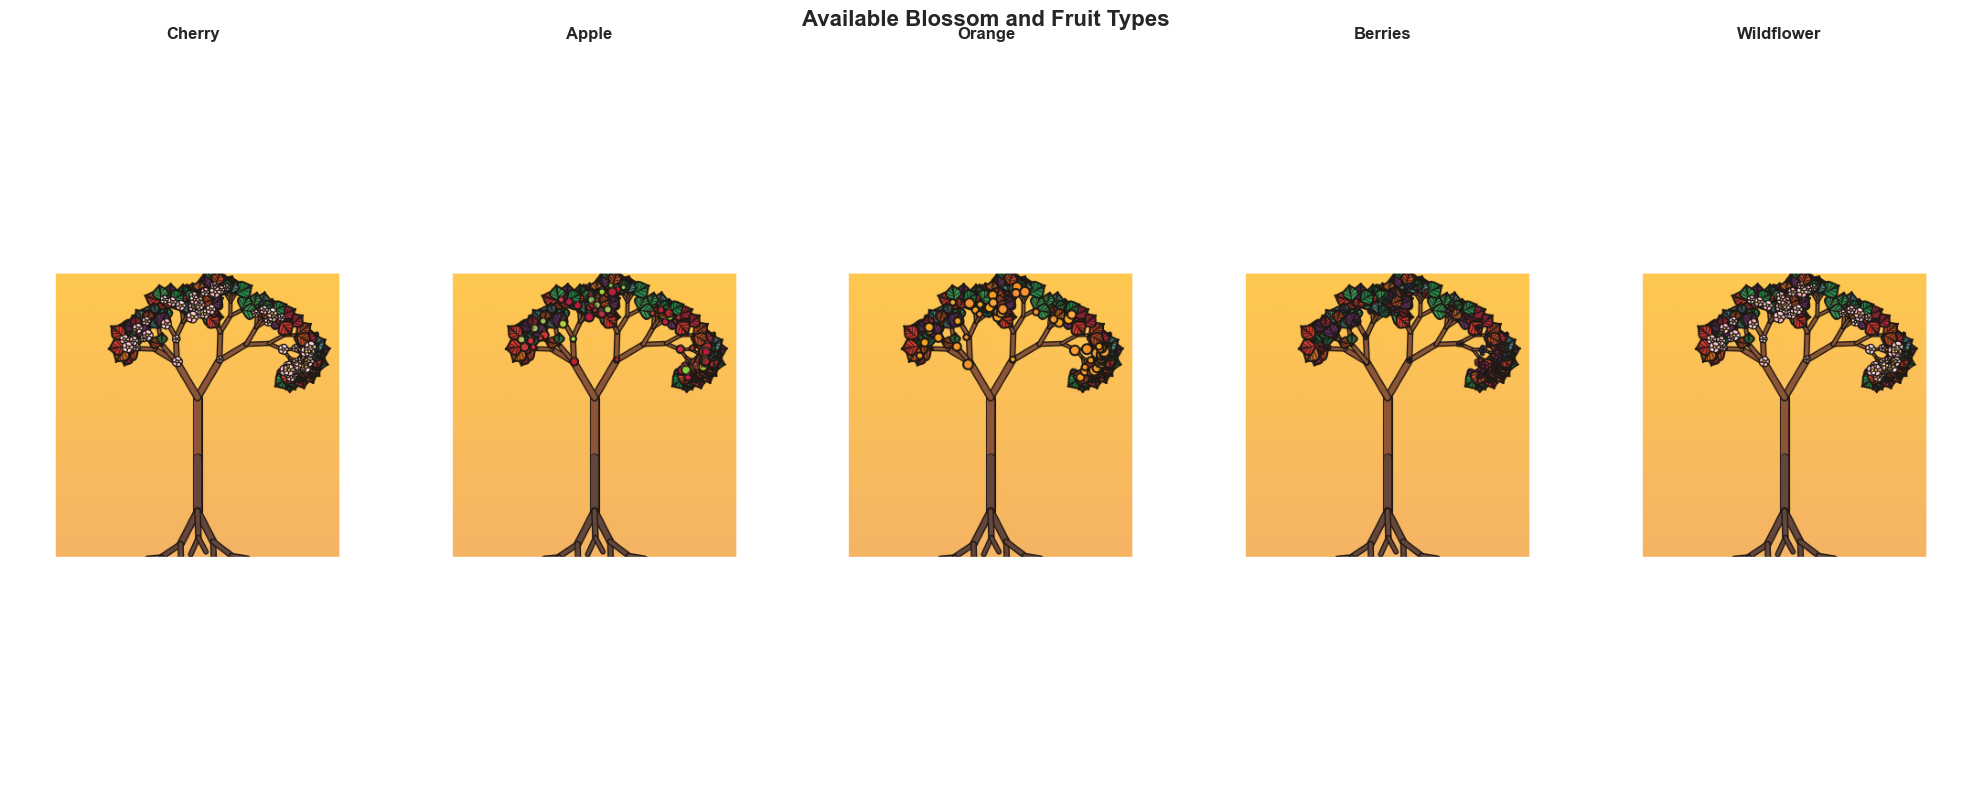

In [9]:
# Compare blossom types
fig, axes = plt.subplots(1, 5, figsize=(20, 8))

blossom_types = ['cherry', 'apple', 'orange', 'berries', 'wildflower']

for ax, btype in zip(axes, blossom_types):
    params = TreeParams(
        depth=5,
        show_blossoms=True,
        blossom_type=btype,
        blossom_density=0.5,
        early_stop=0.15,
    )
    fig_temp, _ = render_tree(params, seed=42, figsize=(4, 8))
    
    fig_temp.canvas.draw()
    img = np.frombuffer(fig_temp.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig_temp.canvas.get_width_height()[::-1] + (4,))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(btype.capitalize(), fontsize=12, fontweight='bold')
    plt.close(fig_temp)

plt.suptitle('Available Blossom and Fruit Types', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Color Palette Variations

The `TreeStyle` class controls visual appearance including leaf color palettes.

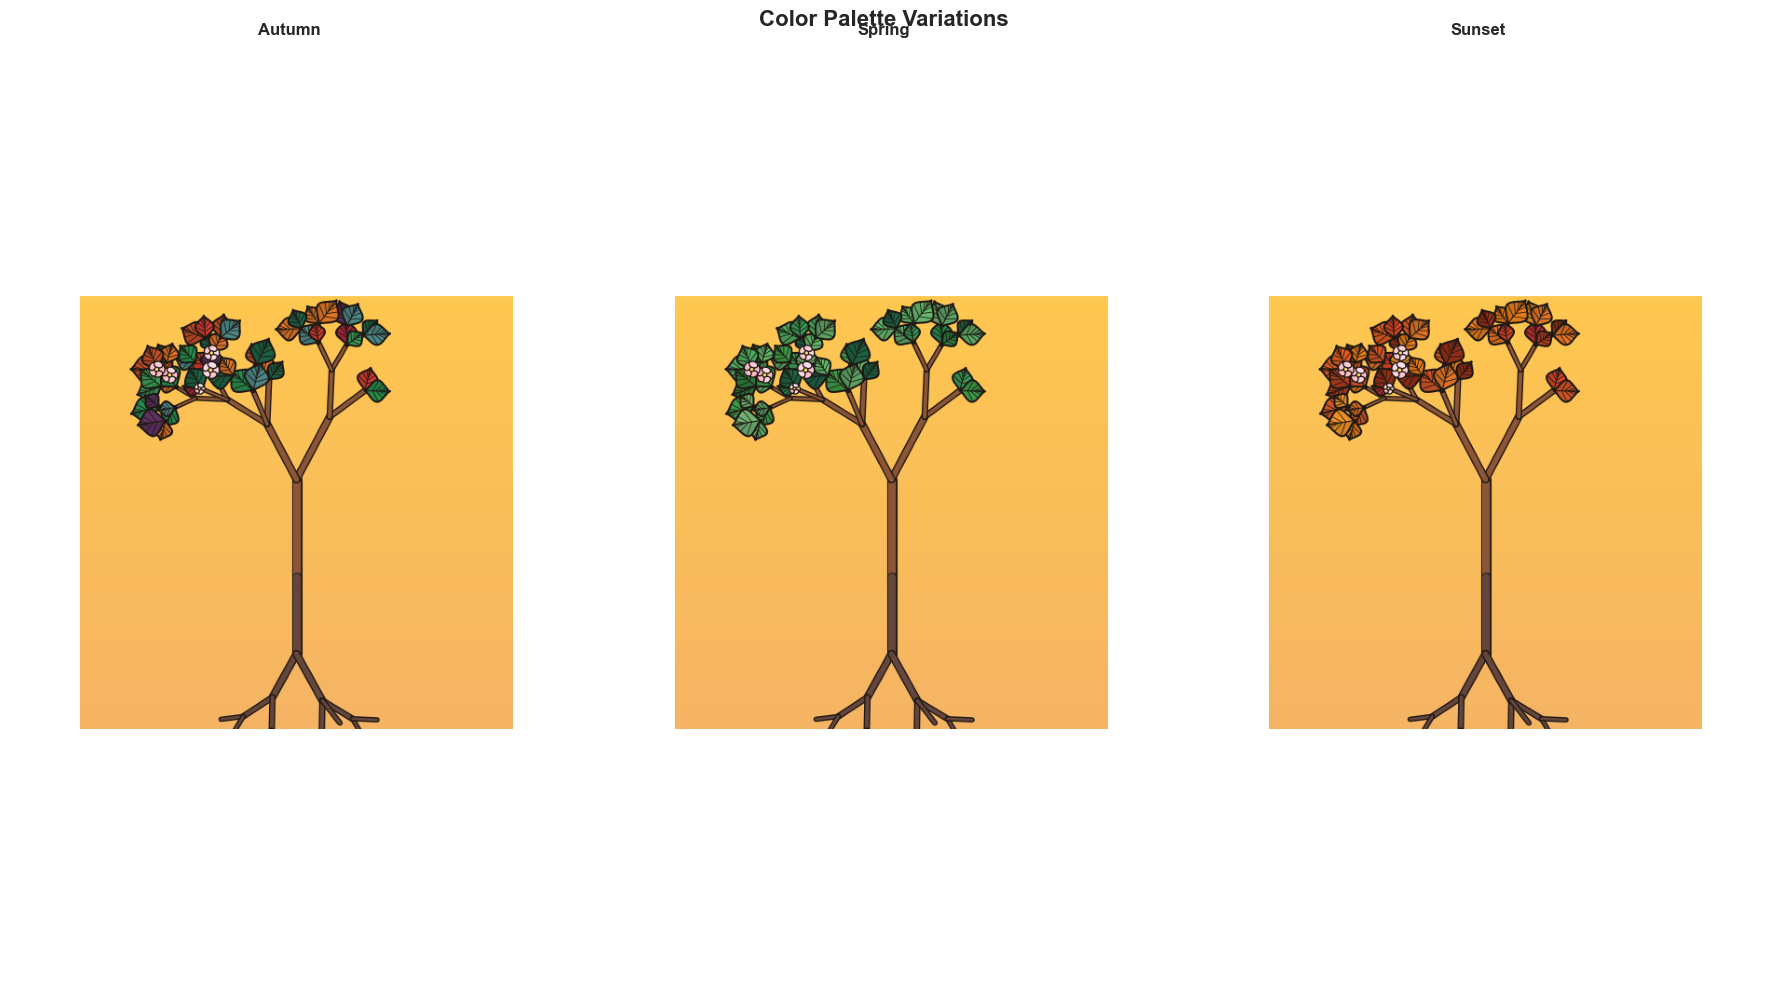

In [10]:
# Define color palettes
autumn_colors = (
    '#b42840', '#dc3c32', '#c85028',
    '#e67828', '#289050', '#3ca05a',
    '#1e6446', '#643264', '#508c8c'
)

spring_colors = (
    '#289050', '#3ca05a', '#50b060',
    '#68c070', '#40a048', '#2e8040',
    '#1e6446', '#78b878', '#60a868'
)

sunset_colors = (
    '#c83030', '#e04828', '#e86020',
    '#f08018', '#d85828', '#b84020',
    '#983018', '#f89828', '#e87828'
)

# Create comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

palettes = [
    (autumn_colors, 'Autumn'),
    (spring_colors, 'Spring'),
    (sunset_colors, 'Sunset'),
]

params = TreeParams(depth=5, show_blossoms=True, blossom_density=0.25)

for ax, (colors, title) in zip(axes, palettes):
    style = TreeStyle(leaf_colors=colors)
    fig_temp, _ = render_tree(params, style, seed=99, figsize=(6, 10))
    
    fig_temp.canvas.draw()
    img = np.frombuffer(fig_temp.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig_temp.canvas.get_width_height()[::-1] + (4,))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.close(fig_temp)

plt.suptitle('Color Palette Variations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Seed Variation

The random seed controls procedural generation, creating unique trees from the same parameters.

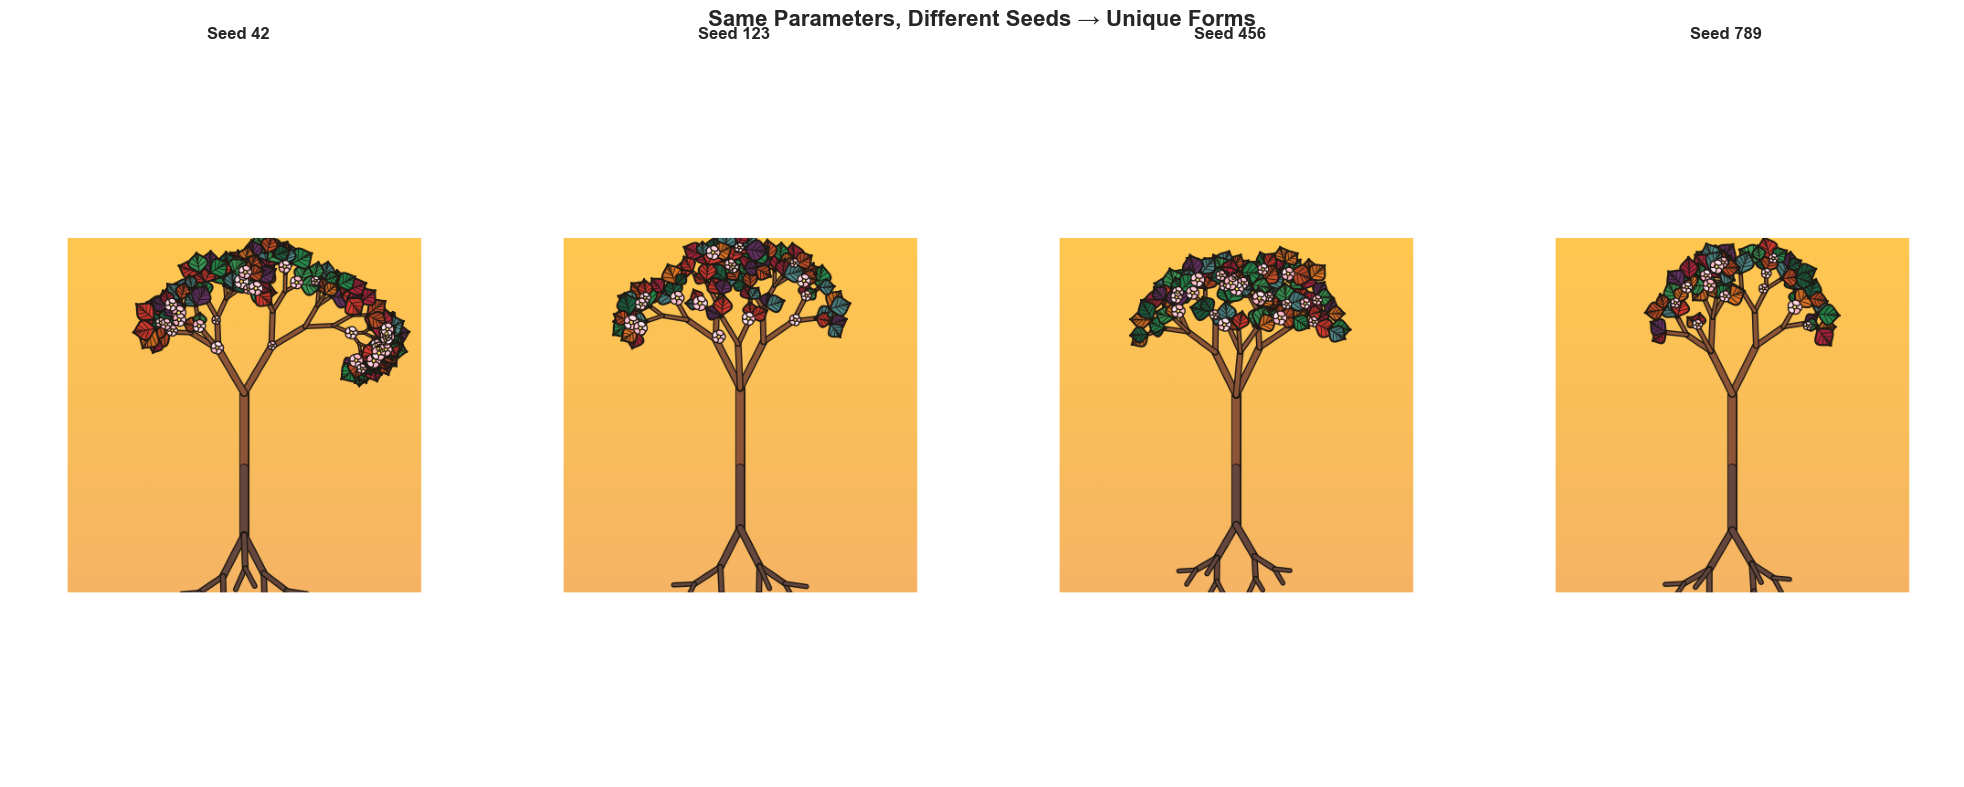

In [11]:
# Show variation from different seeds
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

seeds = [42, 123, 456, 789]
params = TreeParams(depth=5, show_blossoms=True, blossom_density=0.3)

for ax, seed in zip(axes, seeds):
    fig_temp, _ = render_tree(params, seed=seed, figsize=(5, 8))
    
    fig_temp.canvas.draw()
    img = np.frombuffer(fig_temp.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig_temp.canvas.get_width_height()[::-1] + (4,))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Seed {seed}', fontsize=12, fontweight='bold')
    plt.close(fig_temp)

plt.suptitle('Same Parameters, Different Seeds → Unique Forms', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Tree Gallery

A gallery of diverse tree forms created by varying parameters and seeds.

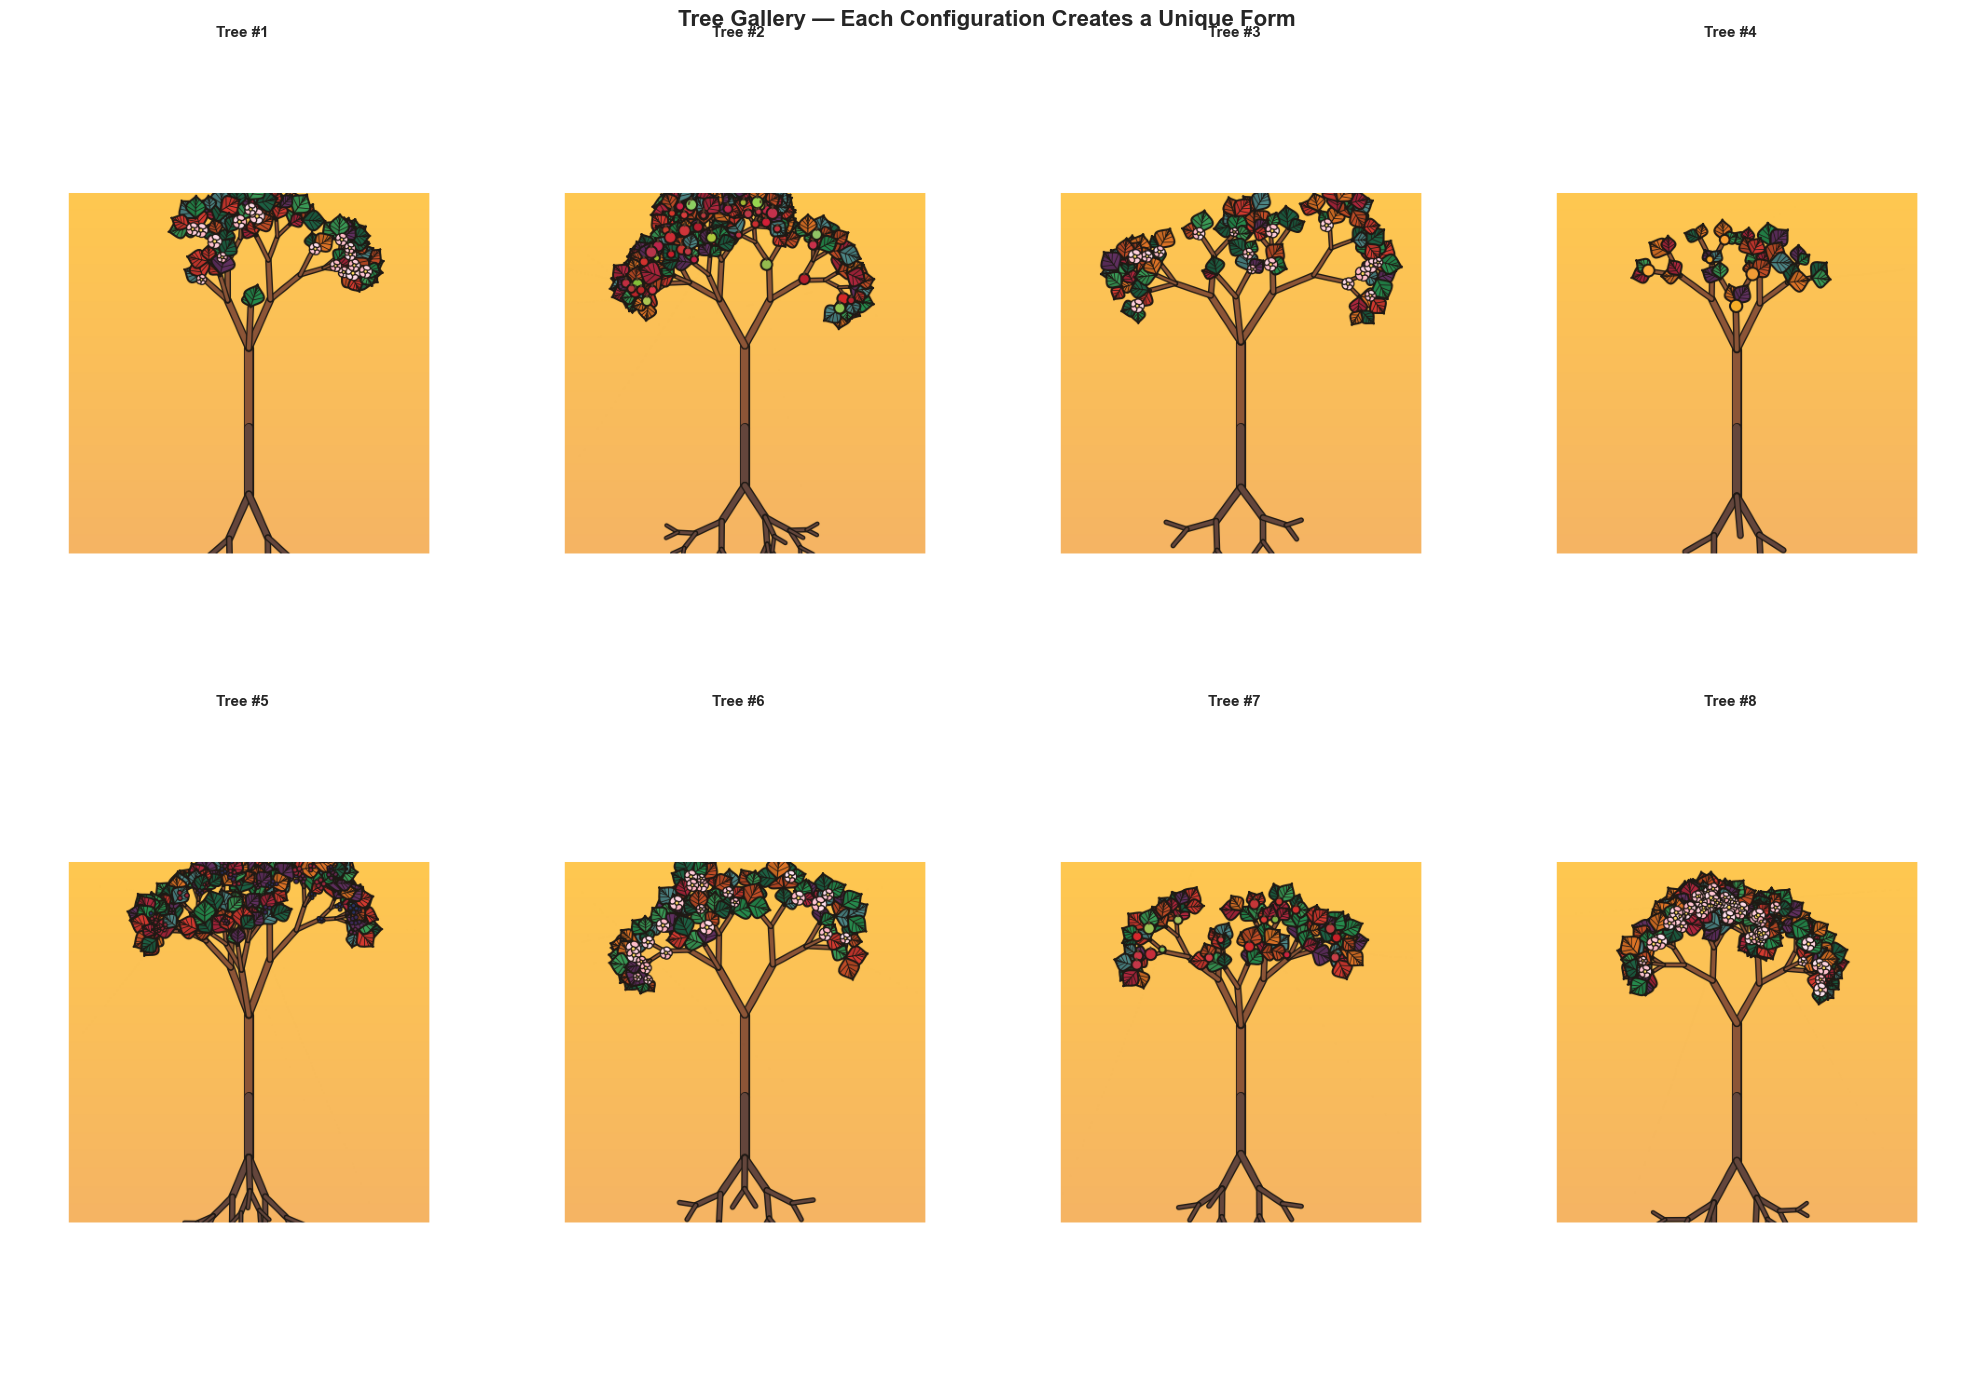

In [12]:
# Gallery of diverse trees
fig, axes = plt.subplots(2, 4, figsize=(20, 14))
axes = axes.flatten()

# Different configurations
configs = [
    {'depth': 5, 'angle': 25, 'blossom_type': 'cherry', 'seed': 100},
    {'depth': 6, 'angle': 30, 'blossom_type': 'apple', 'seed': 123},
    {'depth': 5, 'angle': 35, 'blossom_type': 'wildflower', 'seed': 200},
    {'depth': 4, 'angle': 28, 'blossom_type': 'orange', 'seed': 300},
    {'depth': 6, 'angle': 22, 'blossom_type': 'berries', 'seed': 400},
    {'depth': 5, 'angle': 32, 'blossom_type': 'cherry', 'seed': 500},
    {'depth': 5, 'angle': 26, 'blossom_type': 'apple', 'seed': 600},
    {'depth': 6, 'angle': 30, 'blossom_type': 'wildflower', 'seed': 700},
]

for i, (ax, cfg) in enumerate(zip(axes, configs)):
    seed = cfg.pop('seed')
    params = TreeParams(
        show_blossoms=True,
        blossom_density=0.35,
        early_stop=0.12 + 0.05 * np.sin(i * 0.8),
        **cfg
    )
    fig_temp, _ = render_tree(params, seed=seed, figsize=(5, 7))
    
    fig_temp.canvas.draw()
    img = np.frombuffer(fig_temp.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig_temp.canvas.get_width_height()[::-1] + (4,))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Tree #{i+1}', fontsize=11, fontweight='bold')
    plt.close(fig_temp)

plt.suptitle('Tree Gallery — Each Configuration Creates a Unique Form', fontsize=16, fontweight='bold')
plt.tight_layout()
fig.savefig('tree_gallery.png', dpi=150, bbox_inches='tight', facecolor='#f5deb3')
plt.show()

## Summary

The tree visualization system provides:

1. **L-System Generation**: Recursive branching with configurable depth, angles, and scale
2. **Parametric Leaves**: Equal-area vein panels with Bézier-curved veins
3. **Multiple Blossom Types**: Cherry, apple, orange, berries, wildflowers
4. **Color Palettes**: Customizable leaf color schemes via TreeStyle
5. **Procedural Variation**: Deterministic generation from seed values

**Key parameters:**
- `TreeParams.depth`: Branching complexity (3-7 recommended)
- `TreeParams.angle`: Branch spread angle (20-40°)
- `TreeParams.early_stop`: Pruning probability for sparse forms
- `TreeParams.blossom_type`: Visual style of flowers/fruit
- `TreeStyle.leaf_colors`: Color palette for leaf panels

**Integration with simulation:**
The stress-morphology integration (see notebook 07) maps simulation trajectories
to these visual parameters, creating trees whose appearance reflects environmental
conditions experienced during growth.